In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from flaml import AutoML
import xgboost
import pickle

In [2]:
# Add time functions
def add_time_features_std(df, time_column):
    
    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year

    return df

def add_time_features_cat(df, time_column):
  
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)

    return df

In [3]:
def add_new_features(df):
    df['SumRad'] = df ['direct_rad:W'] + df['diffuse_rad:W']
    df['SumRad_1h'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
    df['ClearSkyRatio'] = df['SumRad']/(1+df['clear_sky_rad:W'])
    df['TempDewPoint'] = df['t_1000hPa:K'] - df['dew_point_2m:K']
    
    return df

In [4]:
def find_strong_correlation_pairs(data, threshold=0.95):
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Find pairs with strong correlation
    strong_correlation_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                strong_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    # Print pairs with strong correlation
    if strong_correlation_pairs:
        print("Pairs with strong correlation:")
        for pair in strong_correlation_pairs:
            print(f"{pair[0]} and {pair[1]} have a correlation of {correlation_matrix[pair[0]][pair[1]]}")
    else:
        print("No strong correlation pairs found.")
    
    print("\n")
    return strong_correlation_pairs

In [5]:
def clean_outliers_zscore(df, columns, z_threshold):
    cleaned_df = df.copy()
    
    for col in columns:
        z_scores = np.abs((cleaned_df[col] - cleaned_df[col].mean()) / cleaned_df[col].std())
        outliers = z_scores > z_threshold
        cleaned_df.loc[outliers, col] = np.nan  
    
    cleaned_df = cleaned_df.dropna()
    
    return cleaned_df 

In [6]:
# Preprocessing functions

def preprocessing_std(targets, observed, estimated, test):

#Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

#Resample date_calc
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first()

#Convert to pandas dataframe
    date_calc_resampled_ob = date_calc_resampled_ob.to_frame()
    date_calc_resampled_te = date_calc_resampled_te.to_frame()

#Resample dataframes
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
#Merge the obtained results
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)

#Get the 'is_day:idx' feature
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]

#Drop constant columns
    const_columns = ['is_day:idx', 'snow_density:kgm3','elevation:m', 'snow_drift:idx']
    test_resampled = test_resampled.drop(columns =const_columns)
    observed_resampled = observed_resampled.drop(columns = const_columns)
    estimated_resampled = estimated_resampled.drop(columns = const_columns)

#Get starting and ending date
    first_date = targets['time'].min()
    last_date = targets['time'].max()

    print('{firs_date}, {second_date}')

#Add time delta variable 
    estimated_resampled['time_dummy'] = (estimated_resampled['date_forecast'] - estimated_resampled['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    observed_resampled['time_dummy'] = 0
    test_resampled['time_dummy'] = (test_resampled['date_forecast'] - test_resampled['date_forecast'].dt.normalize()).dt.total_seconds() / 3600

    estimated_resampled['time_delta'] = (estimated_resampled['date_calc'] - estimated_resampled['date_forecast']).dt.total_seconds() / 3600
    observed_resampled['time_delta'] = 0  # since observed data is not forecasting ahead
    test_resampled['time_delta'] = (test_resampled['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600

#Add indicator variable for estimated data
    estimated_resampled['is_estimated'] = 1
    observed_resampled['is_estimated'] = 0
    test_resampled['is_estimated'] = 1

#Concatenate data
    weather_df = pd.concat([observed_resampled, estimated_resampled], axis=0).sort_values(by='date_forecast')
    print(weather_df)

    weather_df = weather_df.reset_index(drop=True)

#Remove outliers
#targets=clean_outliers_zscore(targets, ['pv_measurement'], 5)
#Does not improve score

# Merge with target values
    merged_data = pd.merge(targets, weather_df, how='inner', left_on='time', right_on='date_forecast')
    print(merged_data)
    
# Check if merged_data is empty
    print(merged_data)

# Remove rows where 'pv_measurement' is 0
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

# Remove constant stretches
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = merged_data.groupby('block')['constant'].sum()
    constant_blocks = block_sizes[block_sizes > 2].index
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]

#Remove too highly correlated columns
    find_strong_correlation_pairs(merged_data, threshold=0.98)
    
    corr_col = ['pressure_50m:hPa', 
    'pressure_100m:hPa', 
    'sfc_pressure:hPa']

    filtered_data = filtered_data.drop(columns=corr_col)
    test_resampled = test_resampled.drop(columns= corr_col)

# Extract relevant columns from filtered_data
    targets_new = filtered_data[['time', 'pv_measurement']]

# Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block', 'time', 'pv_measurement', 'date_calc'])
    test_resampled = test_resampled.drop(columns=['date_calc'])   

# Check if observed_resampled is empty
    print(observed_resampled)

    return filtered_data, test_resampled, is_day_feature, targets_new

In [7]:
def process_location_flaml(X, y, X_test):
   
    # Initialize the AutoML object
    automl = AutoML()

    # Search for the best regression model and hyperparameters
    automl.fit(X_train=X, y_train=y['pv_measurement'], task="regression", time_budget = 60, metric = 'mae', estimator_list=["xgboost", "rf", "lgbm"])
    automl.model.estimator
    
    # Get the best model
    with open("automl.pkl", "wb") as f:
        pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
           
    # At prediction time
    automl = pickle.load(open('automl.pkl', 'rb'))   
    predictions_auto = automl.predict(X_test)

    return predictions_auto
    


In [9]:
locations = ['A', 'B', 'C']
all_predictions_auto = []
all_predictions_cat = []

for loc in locations:
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    X_train, X_test, is_day_feature, targets = preprocessing_std(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = targets

    X_train=add_new_features(X_train)
    X_test=add_new_features(X_test)
    
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]

    targets_lgb = add_time_features_std(targets, 'time')
    X_train_lgb = add_time_features_std(X_train, 'date_forecast')
    X_test_lgb = add_time_features_std(X_test, 'date_forecast')

    targets_cat = add_time_features_cat(targets, 'time')
    X_train_cat = add_time_features_cat(X_train, 'date_forecast')
    X_test_cat = add_time_features_cat(X_test, 'date_forecast')

    X_train_cat['dew_or_rime:idx'] = X_train_cat['dew_or_rime:idx'].astype(int)
    X_train_cat['is_in_shadow:idx'] = X_train_cat['is_in_shadow:idx'].astype(int)

    X_test_cat['dew_or_rime:idx'] = X_test_cat['dew_or_rime:idx'].astype(int)
    X_test_cat['is_in_shadow:idx'] = X_test_cat['is_in_shadow:idx'].astype(int)

   

#Training and predicting using catboost model

    model_cat = CatBoostRegressor(loss_function='MAE', learning_rate=0.1, verbose=200)
    
    param_grid = {
        'depth': [6, 8, 10],               # Tree depth
        'iterations': [100, 200, 300],     # Number of boosting iterations
        'l2_leaf_reg': [1, 3, 5],         # L2 regularization
    }

# Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=model_cat, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)

# Fit the GridSearchCV on your training data
    grid_search.fit(X_train_cat, targets_cat['pv_measurement'])

# Print the best hyperparameters and corresponding MAE score
    print("Best hyperparameters: ", grid_search.best_params_)
    print("Best MAE score: ", -grid_search.best_score_)

# Get the best model
    best_model_cat = grid_search.best_estimator_ 
    
# Best HP for locations: 
# Best hyperparameters: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1} for A
# Best hyperparameters:  {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5} for B 
# Best hyperparameters:  {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5} for C

    predictions_cat = best_model_cat.predict(X_test_cat)
    adjusted_final_predictions_cat = predictions_cat * is_day_feature['is_day:idx']
    adjusted_final_predictions_cat = np.clip(adjusted_final_predictions_cat, 0, None)

    X_train_lgb = X_train_lgb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X_test_lgb = X_test_lgb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    y_train = y_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#Training and predicting auto tuned model (flaml)
    predictions_auto = process_location_flaml(X_train_lgb, y_train, X_test_lgb)
    adjusted_final_predictions_auto = predictions_auto * is_day_feature['is_day:idx']
    adjusted_final_predictions_auto = np.clip(adjusted_final_predictions_auto, 0, None)

    all_predictions_cat.append(adjusted_final_predictions_cat)
    all_predictions_auto.append([adjusted_final_predictions_auto])  


FileNotFoundError: [Errno 2] No such file or directory: 'A/train_targets.parquet'

In [ ]:
all_predictions_auto = np.array(all_predictions_auto).flatten()
all_predictions_cat = np.array(all_predictions_cat).flatten()                                                                                                               


(2160,)


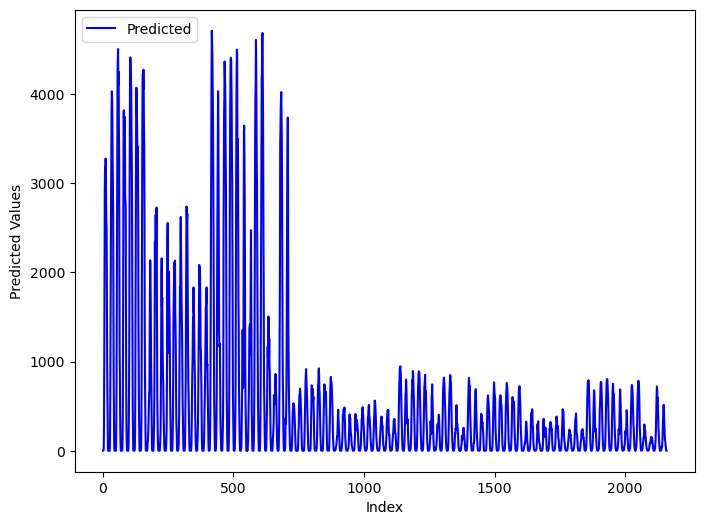

In [ ]:
all_pred = 0.8*all_predictions_auto  +  0.2*all_predictions_cat
print(all_pred.shape)

final_predictions = all_pred

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions_cat_main.csv', index=False)

plt.figure(figsize=(8, 6))
plt.plot(range(len(final_predictions)), final_predictions,  c='blue', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.legend(loc='upper left')

plt.show()